## Why most trading strategy doesn't work!

<b> YouTube Tutorial </b> (Published: Feb 10, 2022): https://youtu.be/_j5HP2wrBPE

The Perils of Multiple Testing - p-hacking during backtesting.

### There are many "false postive" trading strategies. Not lal positive strategy are robust and strong.
Approximately 86% of false discoveries

The significance level, often denoted by 𝛼, is a threshold set by the researcher before conducting a hypothesis test. It represents the probability of rejecting the null hypothesis when it is actually true (a Type I error).


A p-value measures wether an observed result can be attributed to a chance 

The p-value is the probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is true. It quantifies the evidence against the null hypothesis:

Low p-value (≤ 0.05): Indicates strong evidence against the null hypothesis, suggesting it should be rejected.
High p-value (> 0.05): Indicates weak evidence against the null hypothesis, suggesting it should not be rejected.






When we do multiple testing, the family wise significance level goes for above the 5% level 

### Let's show an exemple of Multiple Testing that gives a false positive trading strategy

In [27]:
import datetime
import time
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import backtrader as bt
from itertools import product
import yfinance as yf


In [67]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    return stockData

stockList = ['AAPL']
endDate = datetime.datetime.now() - datetime.timedelta(days=600)
startDate = endDate - datetime.timedelta(days=2630)

stockData = get_data(stockList[0], startDate, endDate)

stockData = stockData.sort_values(by="Date")

stockData_IS = stockData[:int(len(stockData)*0.75)]
stockData_OS = stockData[-int(len(stockData)*0.25):]

print(len(stockData), len(stockData_IS), len(stockData_OS))

actualStart = stockData.index[0]

data = bt.feeds.PandasData(dataname=stockData_IS)

stockData_IS

[*********************100%%**********************]  1 of 1 completed

1814 1360 453


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-21,33.212502,33.230000,32.580002,32.687500,29.420612,307025600
2015-07-22,30.497499,31.375000,30.497499,31.305000,28.176287,461802400
2015-07-23,31.549999,31.772499,31.264999,31.290001,28.162785,203998000
2015-07-24,31.330000,31.434999,30.975000,31.125000,28.014271,168649200
2015-07-27,30.772499,30.902500,30.530001,30.692499,27.624998,177822000
...,...,...,...,...,...,...
2020-12-04,122.599998,122.860001,121.519997,122.250000,119.812805,78260400
2020-12-07,122.309998,124.570000,122.250000,123.750000,121.282913,86712000
2020-12-08,124.370003,124.980003,123.089996,124.379997,121.900337,82225500


## Separate data into two sections: In Sample and Out of Sample

In [68]:
print('IS DATA: starting ', stockData_IS.index[0],' finshing ', stockData_IS.index[-1])
print('OS DATA: starting ', stockData_OS.index[0],' finshing ', stockData_OS.index[-1])

IS DATA: starting  2015-07-21 00:00:00  finshing  2020-12-10 00:00:00
OS DATA: starting  2020-12-14 00:00:00  finshing  2022-09-30 00:00:00


## Strategy Class to define the indicators and logic of Moving Average cross over strat

In [69]:
class MAcrossover(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=20   # period for the slow moving average
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
#         print(f'{dt.isoformat()} {txt}') # Comment this line when running optimization

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # An active Buy/Sell order has been submitted/accepted - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


## Fixed commission Scheme
 - unrealistic (but will do for now)
 - hard to implement correctly with changes in risk sizer

In [70]:
class FixedCommisionScheme(bt.CommInfoBase):
    paras = (
        ('commission', 10),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED)
    )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

## Risk sizer with risk parameter (% of capital)

In [71]:
class maxRiskSizer(bt.Sizer):
    '''
    Returns the number of shares rounded down that can be purchased for the
    max rish tolerance
    '''
        # list of parameters which are configurable for the strategy
    params = dict(
        prisk=0.35
    )

    def __init__(self):
        if self.p.prisk > 1 or self.p.prisk < 0:
            raise ValueError('The risk parameter is a percentage which must be'
                'entered as a float. e.g. 0.5')

    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy == True:
            size = math.floor((cash * self.p.prisk) / data[0])
        else:
            size = math.floor((cash * self.p.prisk) / data[0]) * -1
        return size

In [72]:
optimized_runs = {}

In [73]:
def run(data, params, graph=False, benchmark=False):
    #Add Data
    cerebro = bt.Cerebro()
    cerebro.adddata(data)

    #Analyzers
    cerebro.addanalyzer(bt.analyzers.AnnualReturn)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe_ratio')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommisionScheme()
    cerebro.broker.addcommissioninfo(comminfo)
    cerebro.broker.set_cash(10000)

    # Add Strategy
    if benchmark:
        cerebro.addstrategy(BuyAndHold)
    else:
        cerebro.addstrategy(MAcrossover, pfast=params[0],pslow=params[1])

        #Default position size
        cerebro.addsizer(maxRiskSizer, prisk=params[2])

    strats = cerebro.run()
    if graph:
        cerebro.plot(iplot=False, style='candlestick')
    return strats

## List of parameter permutations

In [74]:
pfast=range(5,20,5)
pslow=range(50,100,10)
prisk=np.linspace(0.1,1,9)

params = list(product(pfast, pslow, prisk))
len(params)

135

## Let the scenarios (multiple tests) rip

In [75]:
start = time.time()
for param in params:
    print(param)
    optimized_runs[param] = run(data, param)
end = time.time()
print('  time taken {:.2f} s'.format(end-start))

(5, 50, 0.1)
(5, 50, 0.21250000000000002)
(5, 50, 0.325)
(5, 50, 0.4375)
(5, 50, 0.55)
(5, 50, 0.6625)
(5, 50, 0.775)
(5, 50, 0.8875)
(5, 50, 1.0)
(5, 60, 0.1)
(5, 60, 0.21250000000000002)
(5, 60, 0.325)
(5, 60, 0.4375)
(5, 60, 0.55)
(5, 60, 0.6625)
(5, 60, 0.775)
(5, 60, 0.8875)
(5, 60, 1.0)
(5, 70, 0.1)
(5, 70, 0.21250000000000002)
(5, 70, 0.325)
(5, 70, 0.4375)
(5, 70, 0.55)
(5, 70, 0.6625)
(5, 70, 0.775)
(5, 70, 0.8875)
(5, 70, 1.0)
(5, 80, 0.1)
(5, 80, 0.21250000000000002)
(5, 80, 0.325)
(5, 80, 0.4375)
(5, 80, 0.55)
(5, 80, 0.6625)
(5, 80, 0.775)
(5, 80, 0.8875)
(5, 80, 1.0)
(5, 90, 0.1)
(5, 90, 0.21250000000000002)
(5, 90, 0.325)
(5, 90, 0.4375)
(5, 90, 0.55)
(5, 90, 0.6625)
(5, 90, 0.775)
(5, 90, 0.8875)
(5, 90, 1.0)
(10, 50, 0.1)
(10, 50, 0.21250000000000002)
(10, 50, 0.325)
(10, 50, 0.4375)
(10, 50, 0.55)
(10, 50, 0.6625)
(10, 50, 0.775)
(10, 50, 0.8875)
(10, 50, 1.0)
(10, 60, 0.1)
(10, 60, 0.21250000000000002)
(10, 60, 0.325)
(10, 60, 0.4375)
(10, 60, 0.55)
(10, 60, 0.6625)


In [76]:
import quantstats

In [77]:
final_results_list = []
for runs in optimized_runs:
    for strategy in optimized_runs[runs]:
        PnL = round(strategy.broker.get_value() - 10000,2)
        sharpe = strategy.analyzers.sharpe_ratio.get_analysis()
        final_results_list.append([strategy.params.pfast,
            strategy.params.pslow, round(runs[2],1), PnL, round(sharpe['sharperatio'],2)])

sort_by_sharpe = sorted(final_results_list, key=lambda x: x[3],
                         reverse=True)

sort_by_sharpe = sorted(sort_by_sharpe, key=lambda x: x[4],
                         reverse=True)
for line in sort_by_sharpe[:5]:
    print(line)

len(optimized_runs)

[5, 50, 1.0, 27045.71, 1.03]
[5, 50, 0.9, 22683.88, 1.03]
[5, 50, 0.8, 18695.92, 1.03]
[5, 50, 0.7, 15041.34, 1.03]
[5, 50, 0.6, 11745.5, 1.02]


135

## In Sample Test

Test historical walk-forward 'optimised' parameter combination

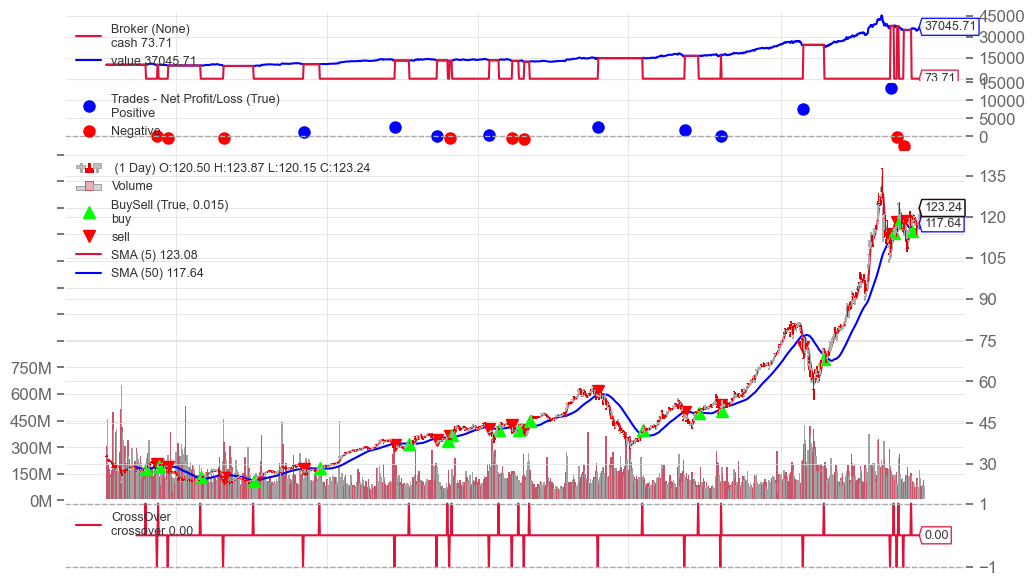

In [78]:
strats = run(data,(5,50,1), graph=True)

In [79]:
strat_0 = strats[0]
portfolio_stats = strat_0.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
sharpe_quantstats = quantstats.stats.sharpe(returns)
vol = np.std(returns)*np.sqrt(252)
returns.index = returns.index.tz_convert(None)
PnL = round(strat_0.broker.get_value() - 10000,2)

sharpe = strat_0.analyzers.sharpe_ratio.get_analysis()

print('PnL $                  : ',round(PnL,2))
print('Sharpe Ratio           : ',round(sharpe['sharperatio'],2))
print( 'sharpe quantstats', sharpe_quantstats)
print('Annualised Volatility %: ', round(vol*100,2))

PnL $                  :  27045.71
Sharpe Ratio           :  1.03
sharpe quantstats 1.3149573411769397
Annualised Volatility %:  19.97


## Complete hypothesis test

- null hypothesis: there is no difference between our result and a portfolio with a 0 sharpe ratio

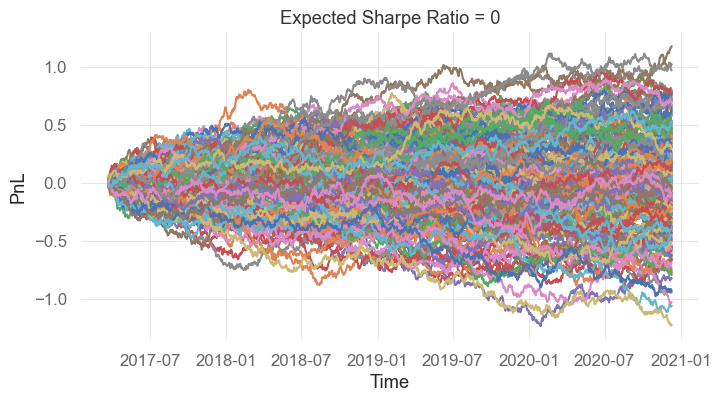

In [80]:
fig = plt.figure(figsize=(8,4))
sharperatios=np.random.normal(0, vol*np.sqrt(1/252), (len(stockData_IS), 200))
dates=pd.date_range(end = stockData_IS.index[-1], periods = len(stockData_IS)).to_pydatetime().tolist()
plt.plot(dates, np.cumsum(sharperatios,axis=0))
plt.xlabel('Time')
plt.ylabel('PnL')
plt.title('Expected Sharpe Ratio = 0')
plt.show()

T-Distribution:
The t-distribution is a type of probability distribution that is symmetric and bell-shaped, like the normal distribution, but has heavier tails. This means it is more prone to producing values that fall far from its mean.
The shape of the t-distribution is determined by the degrees of freedom (df). As the sample size increases (and thus df increases), the t-distribution approaches the normal distribution.

$\large T-statistic = Sharpe Ratio \times \sqrt{\# Years}$

$\large T-statistic = 1.23 \times \sqrt{\frac{1033}{252}}$          -     365 for crypto

$\large T-statistic = 2.5$

In [81]:
t_statistic = 0.66*np.sqrt(1033/252)
t_statistic

1.3362687924644074

In [82]:
alpha = 0.05
df = 999  # Example degrees of freedom

t_statistic = sharpe['sharperatio']*np.sqrt(len(stockData_IS)/252)
print('Our T-statistic: ',round(t_statistic,2))

# Calculate p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df))
print('p_value:', round(p_value, 3))

# Calculate critical value at 5% significance level
t_crit = stats.t.ppf(1 - 0.05 / 2, df)
print('T crit at 5% CI:', round(t_crit, 3))

Our T-statistic:  2.4
p_value: 0.017
T crit at 5% CI: 1.962


If our T-statisitc > T-crit at 5% confidence interval so we should reject the H0 and conclude that our strategudon't follow the same distribution as a portefolio of sharpe ratio = 0.

Is it the correct conclusion ?

## Out of Sample Test

Test historical walk-forward 'optimised' parameter combination

In [83]:
data_OS = bt.feeds.PandasData(dataname=stockData_OS)

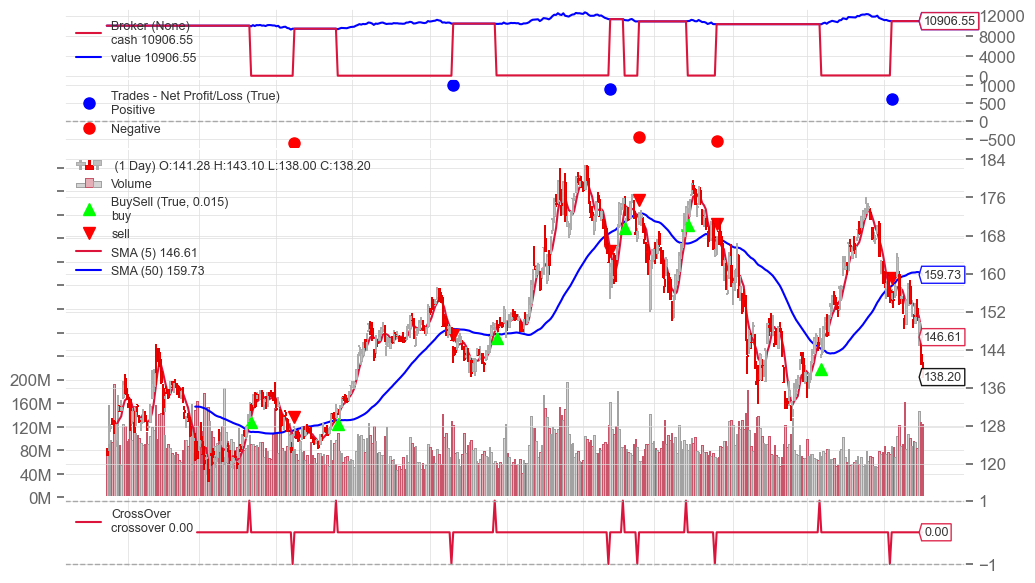

In [84]:
strats = run(data_OS,(5,50,1), graph=True)

In [85]:
strat_0 = strats[0]
portfolio_stats = strat_0.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
vol = np.std(returns)*np.sqrt(252)
returns.index = returns.index.tz_convert(None)
PnL = round(strat_0.broker.get_value() - 10000,2)

sharpe = strat_0.analyzers.sharpe_ratio.get_analysis()

print('PnL $                  : ',round(PnL,2))
print('Sharpe Ratio           : ',round(sharpe['sharperatio'],2))
print('Annualised Volatility %: ', round(vol*100,2))

PnL $                  :  906.55
Sharpe Ratio           :  0.2
Annualised Volatility %:  16.33


## Why does this strategy vastly underperform

Maybe it's not a true strategy and we made a false discovery.

You need to account for **multiple testing**, when we 'optimised' the parameters we ran 216 tests.

In [86]:
print('T_crit at adjusted Bonferroni t-stat', round(stats.t.ppf(1-0.05/216,999),3))

T_crit at adjusted Bonferroni t-stat 3.513




> Hence we would not reject the null hypothesis when considering multiple testing!


> Without considering multiple testing under a framework like the Bonferroni method we would lead to a higher rate of false discoveries



